# Capstone Final Project
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Exploring the data](#exploring)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**Boston and San Francisco** are two large cities in United States. Both cities being cities by the bay and both metro area sharing a similar population (Boston population around 4.9 million and San Francisco 4.7 million). Given that both cities are in opposite ends of the country, it would be interesting to compare both of their neighborhood, with the power of machine learning, to observe how the resemble each other or differ from each other.
**This analysis is intended to show which areas of one city resemble those of the other: Boston and San Francisco. This could be helpful for different use case**:
* People moving between cities would like to live in a very specific type of neighborhood. This study could be useful to filter similar neighborhoods in both places.
* Companies expanding from one city to the other might also try to find a neighborhood to settle in first. They can use their experience from the original city and look for a fitting area in the second one.




## DATA <a name="data"></a>

For this project the Foursquare API will be used. A list of neighborhoods in Boston and San Francisco is downloaded and their respective location in longitude and latitude coordinates is obtained. The sources are the following:

    Boston neighborhoods: https://www.kaggle.com/yingzhou474/boston-neighborhoods-geojson
    San Francisco neighborhoods: https://www.kaggle.com/broach/san-francisco-neighborhood-maps

The data downloaded are the neighborhoods located in Boston and San Francisco. Moreover, their specific coordinates are merged. Then, the Foursquare API GET request is sent in order to adquire the surrounds venues that are within a radius of 500m. The data is formated using one hot encoding with the categories of each venue. Then, the venues are grouped by neighborhoods computing the mean of each feature.

The similarities will be determined based on the frequency of the categories found in the neighborhoods. 

## Exploring the DATA <a name="exploring"></a>

In [1]:
import geopandas as gpd
import numpy as np # library to handle data in a vectorized manner
import seaborn as sns
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge wordcloud==1.4.1 --yes
#from wordcloud import WordCloud, get_single_color_func

#!conda install -c conda-forge folium --yes
import folium # map rendering library
import folium.plugins as plugins
from folium.plugins import MiniMap
print('Libraries imported.')


Libraries imported.


### BOSTON DATA

In [2]:
bos=gpd.read_file('Boston_Neighborhoods.geojson')
print(bos.shape)
bos.head()
bos['City']='Boston'

(26, 8)


In [3]:
bos["Latitude"] = bos.centroid.y
bos["Longitude"] = bos.centroid.x
bos.head()

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles,ShapeSTArea,ShapeSTLength,geometry,City,Latitude,Longitude
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ...",Boston,42.282524,-71.126663
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((-71.10499 42.32610, -71.10503 42.326...",Boston,42.307770,-71.115097
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((-71.09043 42.33577, -71.09050 42.335...",Boston,42.331741,-71.102607
3,30,Longwood,188.611947,28,0.29,8.215904e+06,11908.757148,"POLYGON ((-71.09811 42.33673, -71.09832 42.337...",Boston,42.338609,-71.105103
4,31,Bay Village,26.539839,33,0.04,1.156071e+06,4650.635493,"POLYGON ((-71.06663 42.34878, -71.06663 42.348...",Boston,42.349103,-71.069032


In [4]:
BOS=bos.drop(['OBJECTID','OBJECTID','Neighborhood_ID','SqMiles','ShapeSTArea',
              'ShapeSTLength','geometry','Acres'],
            axis=1)
BOS.rename(columns={'Name':'Neighborhood'},inplace=True)
BOS.at[25,'Latitude']=42.3602
BOS.at[25, 'Longitude']=-71.0524
BOS

,Neighborhood,City,Latitude,Longitude
0,Roslindale,Boston,42.282524,-71.126663
1,Jamaica Plain,Boston,42.307770,-71.115097
2,Mission Hill,Boston,42.331741,-71.102607
3,Longwood,Boston,42.338609,-71.105103
4,Bay Village,Boston,42.349103,-71.069032
5,Leather District,Boston,42.350983,-71.057828
6,Chinatown,Boston,42.349027,-71.061662
7,North End,Boston,42.365465,-71.053858
8,Roxbury,Boston,42.318519,-71.086643
9,South End,Boston,42.341350,-71.071369


In [5]:
print("{} neighborhoods found in Boston.".format(BOS.shape[0]))

26 neighborhoods found in Boston.


### SAN FRANCSICO DATA

In [6]:
sf=gpd.read_file('Planning Neighborhood Groups Map.geojson')
print(sf.shape)
sf.head()


(37, 2)


,neighborho,geometry
0,Seacliff,"MULTIPOLYGON (((-122.48409 37.78791, -122.4843..."
1,Haight Ashbury,"MULTIPOLYGON (((-122.43596 37.76904, -122.4368..."
2,Outer Mission,"MULTIPOLYGON (((-122.45428 37.70822, -122.4545..."
3,Inner Sunset,"MULTIPOLYGON (((-122.45144 37.75874, -122.4514..."
4,Downtown/Civic Center,"MULTIPOLYGON (((-122.40891 37.79013, -122.4088..."


In [7]:
sf['City']='San Francisco'
sf["Latitude"] = sf.centroid.y
sf["Longitude"] = sf.centroid.x
SF=sf.drop(['geometry'],axis=1)
SF.rename(columns={'neighborho':'Neighborhood'}, inplace=True)
print("{} neighborhoods found in San Francisco.".format(SF.shape[0]))
SF.head()

37 neighborhoods found in San Francisco.


,Neighborhood,City,Latitude,Longitude
0,Seacliff,San Francisco,37.783822,-122.501076
1,Haight Ashbury,San Francisco,37.769292,-122.446347
2,Outer Mission,San Francisco,37.724112,-122.444122
3,Inner Sunset,San Francisco,37.758490,-122.465414
4,Downtown/Civic Center,San Francisco,37.783354,-122.416025


In [8]:
address = 'Boston,MA'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
bos_latitude = location.latitude
bos_longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(bos_latitude, bos_longitude))

address = 'San Francisco'

location = geolocator.geocode(address)
sf_latitude = location.latitude
sf_longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(sf_latitude, sf_longitude))

centerLatitude = (bos_latitude + sf_latitude)/2
centerLongitude = (bos_longitude + sf_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.
The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.

The geograpical central coordinates are 40.0696398, -96.73909865.


#### Mergind both cities data

In [9]:
df = BOS.append(SF, sort=True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df = df[['Neighborhood','City','Latitude','Longitude']]
df

,Neighborhood,City,Latitude,Longitude
0,Roslindale,Boston,42.282524,-71.126663
1,Jamaica Plain,Boston,42.307770,-71.115097
2,Mission Hill,Boston,42.331741,-71.102607
...,...,...,...,...
60,Outer Sunset,San Francisco,37.755434,-122.493804
61,Western Addition,San Francisco,37.780385,-122.433457
62,Golden Gate Park,San Francisco,37.768924,-122.482929


In [10]:
df['Neighborhood'][58] = 'ChinatownSF'

In [11]:
map_df = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=4, width='100%', height='100%')

for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_df)
map_df

### BOSTON MAP

In [12]:
map_df = folium.Map(location=[bos_latitude, bos_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng,  neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_df)

minimap = MiniMap(position = 'topleft', center_fixed = (bos_latitude, bos_longitude), zoom_level_fixed = 8)
minimap.add_to(map_df)

minimap = MiniMap(position='bottomright',  center_fixed = (sf_latitude, sf_longitude), zoom_level_fixed = 8)
minimap.add_to(map_df)
map_df

### SAN FRANCISCO MAP

In [13]:
map_df = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_df)

minimap = MiniMap(position = 'topleft', center_fixed = (bos_latitude, bos_longitude), zoom_level_fixed = 8)
minimap.add_to(map_df)

minimap = MiniMap(position='bottomright',  center_fixed = (sf_latitude, sf_longitude), zoom_level_fixed = 8)
minimap.add_to(map_df)
map_df

### FOURSQUARE API

In [14]:
# credentials
CLIENT_ID = '4HCJVXDFXGCY14FBVLFT0OICK5NJEGNFKTLOAR2EI0N2NTZX'
CLIENT_SECRET = 'L55T5AMCMH1VPYP2FCS1310ST00SDLRKWIYPHMQIHPATWGU1'
VERSION = '20180605'
LIMIT = 150

In [15]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(neighborhood, city, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for neighborhood, city, lat, lng in zip(neighborhood, city, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+neighborhood+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            sortByPopularity=1 
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood,
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'City',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)    

In [16]:
bossf_venues= getNearbyVenues(neighborhood=df['Neighborhood'],
                                   city = df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Roslindale
2 | Jamaica Plain
3 | Mission Hill
4 | Longwood
5 | Bay Village
6 | Leather District
7 | Chinatown
8 | North End
9 | Roxbury
10 | South End
11 | Back Bay
12 | East Boston
13 | Charlestown
14 | West End
15 | Beacon Hill
16 | Downtown
17 | Fenway
18 | Brighton
19 | West Roxbury
20 | Hyde Park
21 | Mattapan
22 | Dorchester
23 | South Boston Waterfront
24 | South Boston
25 | Allston
26 | Harbor Islands
27 | Seacliff
28 | Haight Ashbury
29 | Outer Mission
30 | Inner Sunset
31 | Downtown/Civic Center
32 | Diamond Heights
33 | Lakeshore
34 | Russian Hill
35 | Noe Valley
36 | Treasure Island/YBI
37 | Outer Richmond
38 | Crocker Amazon
39 | Excelsior
40 | Parkside
41 | Financial District
42 | Ocean View
43 | Mission
44 | West of Twin Peaks
45 | Inner Richmond
46 | Marina
47 | Bayview
48 | Visitacion Valley
49 | Pacific Heights
50 | Presidio Heights
51 | South of Market
52 | Glen Park
53 | Potrero Hill
54 | Castro/Upper Market
55 | Twin Peaks
56 | Bernal Heights
57 | Presidio
58 |

In [17]:
bossf_venues

,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roslindale,Boston,42.282524,-71.126663,Fornax Bread Company,42.286171,-71.129760,Bakery
1,Roslindale,Boston,42.282524,-71.126663,Roslindale Square,42.285815,-71.129304,Plaza
2,Roslindale,Boston,42.282524,-71.126663,Roslindale Village Farmers Market,42.286534,-71.128509,Farmers Market
...,...,...,...,...,...,...,...,...
2665,Golden Gate Park,San Francisco,37.768924,-122.482929,Speedway Meadows,37.769468,-122.485564,Park
2666,Golden Gate Park,San Francisco,37.768924,-122.482929,Golden Gate Park Running Path,37.770419,-122.479757,Track
2667,Golden Gate Park,San Francisco,37.768924,-122.482929,MUNI Bus Stop - Fulton & 25th,37.772572,-122.483979,Bus Stop


#### One hot encoding

In [18]:
# one hot encoding
bossf_onehot = pd.get_dummies(bossf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bossf_onehot['City'] = bossf_venues['City']
bossf_onehot['Neighborhood'] = bossf_venues['Neighborhood'] 

bossf_onehot['Neighborhood Latitude'] = bossf_venues['Neighborhood Latitude']
bossf_onehot['Neighborhood Longitude'] = bossf_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [bossf_onehot.columns[-1]] + list(bossf_onehot.columns[:-1])
bossf_onehot = bossf_onehot[fixed_columns]

bossf_grouped = bossf_onehot.groupby(['Neighborhood','City','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(bossf_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
bossf_grouped

,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Lounge,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Planetarium,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas R

## Methodology <a name="methodology"></a>

### 3.1 Feature Extraction
In order to obtain the features, One Hot Encoding is used in terms of categories. Each category represents a venue. After, each category is transformed into a binary classification, with the values being 1 or 0. Moreover, the data is grouped by the neighborhood they are obtained from, using the mean of each neighborhood feature to do calculations. This provides us a venue for each row and each column will contain the frequency of a certain category.

### 3.2 Exploratory Data Analysis
Analyzing graphs containing the most common venues in each city, and comparing between them.


### 3.3	  Unsupervised Machine Learning
A clustering algorithm is implemented in order to obtain similar neighborhood in both cities. In this case, K-Means is used due to its simplicity and its similarity approach to found patterns. 
* K-Means:
K-Means is a clustering algorithm. This algorithm search clusters within the data and the main objective function is to minimize the data dispersion for each cluster. Thus, each group found represents a set of data with a pattern inside the multi-dimensional features. 
 
The number of clusters must be determined before running the algorithm, as it is one of the inputs. Therefore, in order to determine the optimal number of clusters, the elbow method will be utilized. This method consists of a chart that compares the mean square error vs number of clusters is done and the elbow is selected. 


## Analysis <a name="analysis"></a>

In [19]:
bossf_onehot2=bossf_onehot.drop(['Neighborhood Latitude','Neighborhood Longitude'],axis=1)

(25, 3)


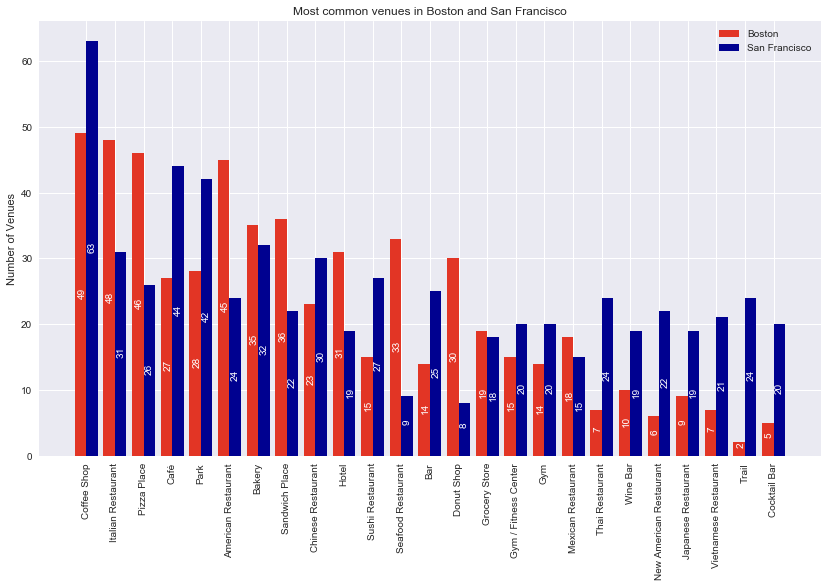

In [44]:
# counting returned venues per city
venue_count = bossf_onehot2.groupby('City').sum().reset_index()
#venue_count.drop('Neighborhood', axis = 1, inplace = True)
venue_count = venue_count.set_index('City').transpose()
venue_count['Total'] = venue_count.sum(axis=1)
venue_count.sort_values(by = ['Total'], inplace = True, ascending = False)

#filter for top 25 venues and sort
venue_count_top25 = venue_count.head(25)
print(venue_count_top25.shape)
venue_count_top25.reset_index(inplace = True)
venue_count_top25.columns = ['Venue', 'Boston', 'San Francisco', 'Total']

#visualize top 25 venues
X = np.arange(25)
width = 0.4

plt.figure(figsize=(14,8), facecolor = 'white')

plt.bar(X + 0.00, venue_count_top25['Boston'], color = '#e23525', width = width)
plt.bar(X + width, venue_count_top25['San Francisco'], color = '#000190', width = width)

plt.ylabel('Number of Venues')
plt.title('Most common venues in Boston and San Francisco')

for s, d in zip(X, venue_count_top25['Boston']):
    plt.annotate(venue_count_top25.Boston[s], xy = (s-0.1,d-d/2), rotation=90, color='white')
for s, d in zip(X, venue_count_top25['San Francisco']):
    plt.annotate(venue_count_top25['San Francisco'][s], xy = (s+0.25,d-d/2), rotation=90, color='white')

plt.xticks(X + width / 2, venue_count_top25['Venue'], rotation='vertical')
plt.legend(labels=venue_count_top25.columns[1:3], loc='best')

plt.show()

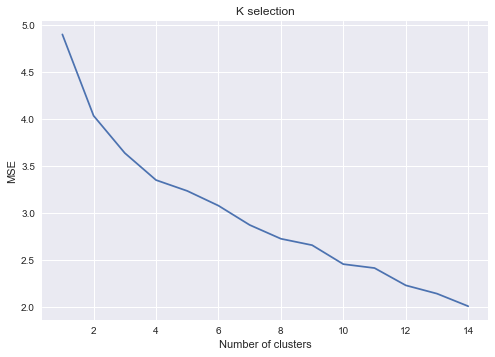

In [21]:
 #Finding best k
plt.style.use("seaborn")
Ks = 15
mse = np.zeros((Ks-1))
bossf_grouped_clustering = bossf_grouped.drop(['Neighborhood','City','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(bossf_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [22]:
# set number of clusters
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(bossf_grouped_clustering)
    
bossf_merged = df
bossf_merged.reset_index()

# add clustering labels
bossf_merged['Cluster Labels'] = kmeans.labels_

bossf_merged

,Neighborhood,City,Latitude,Longitude,Cluster Labels
0,Roslindale,Boston,42.282524,-71.126663,2
1,Jamaica Plain,Boston,42.307770,-71.115097,2
2,Mission Hill,Boston,42.331741,-71.102607,2
...,...,...,...,...,...
60,Outer Sunset,San Francisco,37.755434,-122.493804,2
61,Western Addition,San Francisco,37.780385,-122.433457,3
62,Golden Gate Park,San Francisco,37.768924,-122.482929,2


In [23]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=4, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bossf_merged['Latitude'], bossf_merged['Longitude'], bossf_merged['Neighborhood'], bossf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### BOSTON CLUSTERS MAP

In [24]:
# create map
map_clusters = folium.Map(location=[bos_latitude, bos_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bossf_merged['Latitude'], bossf_merged['Longitude'], bossf_merged['Neighborhood'], bossf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (bos_latitude, bos_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (sf_latitude, sf_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

### SAN FRANCISCO CLUSTERS MAP

In [42]:
# create map
map_clusters = folium.Map(location=[sf_latitude, sf_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bossf_merged['Latitude'], bossf_merged['Longitude'], bossf_merged['Neighborhood'], bossf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (bos_latitude, bos_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (sf_latitude, sf_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [26]:
bossf_grouped_clean=bossf_onehot.groupby('Neighborhood').mean().reset_index()
bossf_grouped_clean=bossf_grouped_clean.drop(['Neighborhood Longitude','Neighborhood Latitude'], axis =1)
bossf_grouped_clean

,Neighborhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Lounge,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Planetarium,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tenn

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#create the new dataframe and display the top 10 venues for each ZIP-code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bossf_venues_sorted = pd.DataFrame(columns=columns)
bossf_venues_sorted['Neighborhood'] = bossf_grouped_clean['Neighborhood']

for ind in np.arange(bossf_grouped_clean.shape[0]):
    bossf_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bossf_grouped_clean.iloc[ind, :], num_top_venues)

#new dataframe that includes the cluster as well as the top 10 venues for each ZIP-code
# add clustering labels
bossf_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged_bossf = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each ZIP-code
merged_bossf = merged_bossf.join(bossf_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='left', lsuffix='_left', rsuffix='_right')
merged_bossf.drop(['Latitude','Longitude','Cluster Labels_right'],axis =1, inplace=True)
merged_clean_bossf = merged_bossf.dropna(subset=['Cluster Labels_left'], axis = 0, inplace = False)
merged_clean_bossf = merged_clean_bossf.astype({'Cluster Labels_left': int})
merged_clean_bossf.rename(columns={'Cluster Labels_left': 'Cluster Labels'}, inplace=True)
print(f'Shape Berlin & Hamburg: {merged_clean_bossf.shape}')
merged_clean_bossf.head()

Shape Berlin & Hamburg: (63, 13)


,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Roslindale,Boston,2,Grocery Store,Pizza Place,Greek Restaurant,Bar,Sandwich Place,Pharmacy,Bakery,Ice Cream Shop,Plaza,Farmers Market
1,Jamaica Plain,Boston,2,Coffee Shop,Pizza Place,Bakery,Pub,Art Gallery,Thrift / Vintage Store,Liquor Store,Bank,Bar,Taco Place
2,Mission Hill,Boston,2,Pizza Place,Liquor Store,Donut Shop,Baseball Field,Sushi Restaurant,Sandwich Place,Burger Joint,Bar,Gastropub,Supermarket
3,Longwood,Boston,0,Café,Coffee Shop,Falafel Restaurant,Gym,Donut Shop,Theater,Sandwich Place,Gastropub,Bus Stop,Bus Station
4,Bay Village,Boston,2,Spa,Theater,Hotel,French Restaurant,Bakery,Seafood Restaurant,Sandwich Place,Performing Arts Venue,American Restaurant,Dive Bar


## Results <a name="results"></a>

In [28]:
CL0 = merged_clean_bossf.loc[merged_clean_bossf['Cluster Labels'] == 0]
CL0

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Longwood,Boston,0,Café,Coffee Shop,Falafel Restaurant,Gym,Donut Shop,Theater,Sandwich Place,Gastropub,Bus Stop,Bus Station
21,Dorchester,Boston,0,Vietnamese Restaurant,Pizza Place,Seafood Restaurant,Café,Ice Cream Shop,Dessert Shop,Supermarket,Music Venue,Baseball Field,Donut Shop
32,Lakeshore,San Francisco,0,Golf Course,Moving Target,College Cafeteria,Zoo Exhibit,Eye Doctor,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant


#### Cluster 1

In [29]:
CL1 = merged_clean_bossf.loc[merged_clean_bossf['Cluster Labels'] == 1]
CL1

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,East Boston,Boston,1,Donut Shop,Airport Lounge,Coffee Shop,Duty-free Shop,Electronics Store,Brewery,American Restaurant,Border Crossing,Wine Bar,Plane
57,Nob Hill,San Francisco,1,Italian Restaurant,Hotel,Café,American Restaurant,Grocery Store,Wine Bar,Spa,Bar,Gym / Fitness Center,French Restaurant
58,ChinatownSF,San Francisco,1,Chinese Restaurant,Bakery,Cocktail Bar,Coffee Shop,Hotel,Italian Restaurant,Dim Sum Restaurant,Szechuan Restaurant,Tea Room,Bubble Tea Shop


#### Cluster 2

In [30]:
CL2 = merged_clean_bossf.loc[merged_clean_bossf['Cluster Labels'] == 2]
CL2

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Roslindale,Boston,2,Grocery Store,Pizza Place,Greek Restaurant,Bar,Sandwich Place,Pharmacy,Bakery,Ice Cream Shop,Plaza,Farmers Market
1,Jamaica Plain,Boston,2,Coffee Shop,Pizza Place,Bakery,Pub,Art Gallery,Thrift / Vintage Store,Liquor Store,Bank,Bar,Taco Place
2,Mission Hill,Boston,2,Pizza Place,Liquor Store,Donut Shop,Baseball Field,Sushi Restaurant,Sandwich Place,Burger Joint,Bar,Gastropub,Supermarket
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,North Beach,San Francisco,2,Café,Pizza Place,Coffee Shop,Trail,Playground,Park,Sandwich Place,Chinese Restaurant,Bakery,Spa
60,Outer Sunset,San Francisco,2,Chinese Restaurant,Dim Sum Restaurant,Pizza Place,Bar,Bank,Bakery,Thai Restaurant,Donut Shop,Fish Market,Grocery Store
62,Golden Gate Park,San Francisco,2,Park,Bus Stop,Track,Disc Golf,Zoo Exhibit,Ethiopian Restaurant,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant


#### Cluster 3

In [31]:
CL3 = merged_clean_bossf.loc[merged_clean_bossf['Cluster Labels'] == 3]
CL3

,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Charlestown,Boston,3,Pizza Place,Donut Shop,Coffee Shop,Pool,Gastropub,Other Repair Shop,Restaurant,Tennis Court,Bank,Café
17,Brighton,Boston,3,Bus Station,Pizza Place,Bakery,Bank,Dry Cleaner,Café,Park,Pub,Chinese Restaurant,Coffee Shop
39,Parkside,San Francisco,3,Dumpling Restaurant,Chinese Restaurant,Bar,Korean Restaurant,Liquor Store,Café,Light Rail Station,Gastropub,Optical Shop,Sushi Restaurant
46,Bayview,San Francisco,3,Park,Gym,Event Space,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Eye Doctor
51,Glen Park,San Francisco,3,Trail,Pizza Place,Gift Shop,Gym,Grocery Store,Bubble Tea Shop,Dog Run,Bakery,Café,Chinese Restaurant
61,Western Addition,San Francisco,3,New American Restaurant,Food Truck,Convenience Store,Spa,Bubble Tea Shop,Seafood Restaurant,Recreation Center,Poke Place,Playground,Pizza Place


In [32]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 400
Cluster 0: 19
Cluster I: 19
Cluster II: 324
Cluster III: 38


<Figure size 576x396 with 0 Axes>

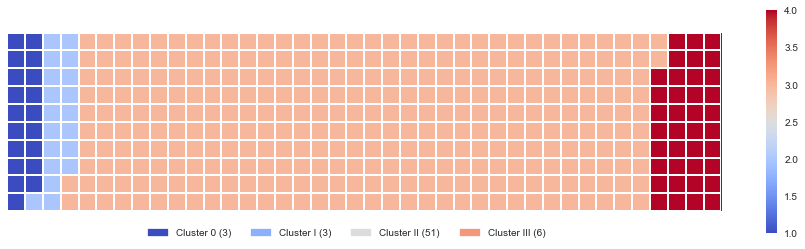

In [34]:
import matplotlib.patches as mpatches
index = ['Cluster 0', 'Cluster I', 'Cluster II', 'Cluster III']
portions = [CL0.shape[0], CL1.shape[0], CL2.shape[0], CL3.shape[0]]
width = 40 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)

In [35]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[0,:]
tmp[1,:] = kmeans.cluster_centers_[1,:]
tmp[2,:] = kmeans.cluster_centers_[2,:]
tmp[3,:] = kmeans.cluster_centers_[3,:]

maxi = []
for i in range(4):
    maxi.extend(tmp[i,:].argsort()[-4:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster 0', 'Cluster I', 'Cluster II', 'Cluster III'], columns = bossf_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

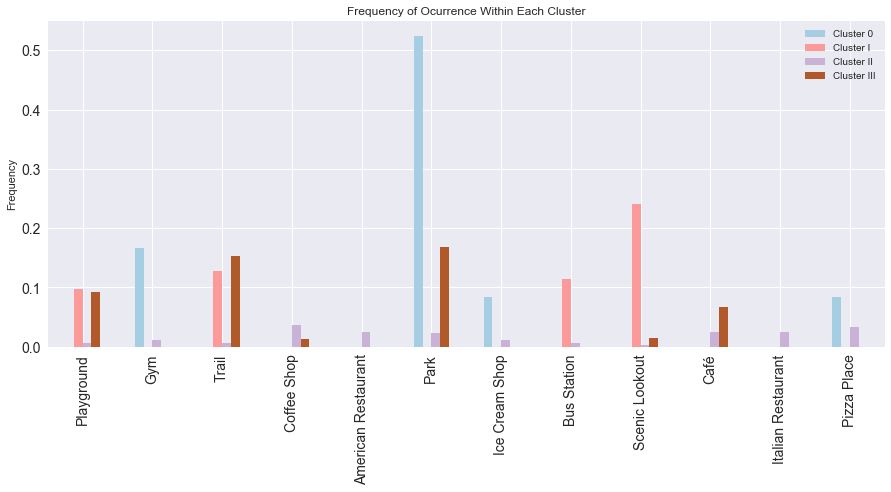

In [36]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [37]:
merged_left = pd.merge(left=bossf_onehot, right=bossf_merged, how='left', left_on='Neighborhood', right_on='Neighborhood')
merged_left=merged_left.drop(['City_x','Neighborhood Latitude','City_y','Latitude','Longitude','Neighborhood Longitude'], axis =1)
merged_left

,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Lounge,Alternative Healer,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Gym,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jiangsu Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Plane,Planetarium,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Resort,Restaurant,Rock Club,Roof Deck,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tenn

(10, 5)


Text(0.5, 1.0, 'Most frequent venues per Cluster 0')

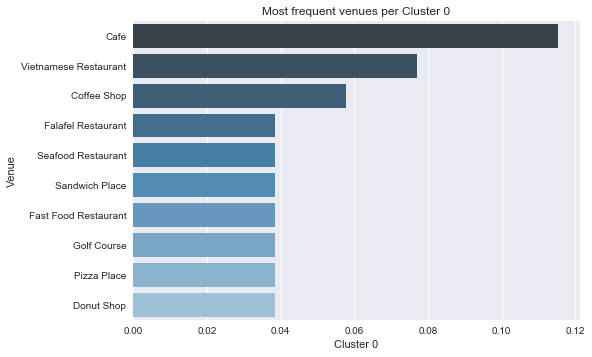

In [38]:
venue_frequency=merged_left.groupby('Cluster Labels').mean().reset_index()
venue_frequency= venue_frequency.set_index('Cluster Labels').transpose()
venue_frequency.reset_index(inplace = True)
venue_frequency.columns = ['Venue', 'Cluster 0', 'Cluster 1','Cluster 2','Cluster 3']
venue_frequency.sort_values(by = ['Cluster 0'], inplace = True, ascending = False)
venue_frequency_top10 = venue_frequency.head(10)
print(venue_frequency_top10.shape)
venue_frequency_top10.reset_index(inplace = True)
venue_frequency_top10=venue_frequency_top10.drop(['Cluster 1','Cluster 2','Cluster 3'],axis=1)
#venue_frequency_top10.sort_values(by = ['Cluster 0'],ascending=False)
ax = sns.barplot(x="Cluster 0", y="Venue", data=venue_frequency_top10,palette="Blues_d")
ax.set_title('Most frequent venues per Cluster 0')

(10, 5)


Text(0.5, 1.0, 'Most frequent venues per Cluster 1')

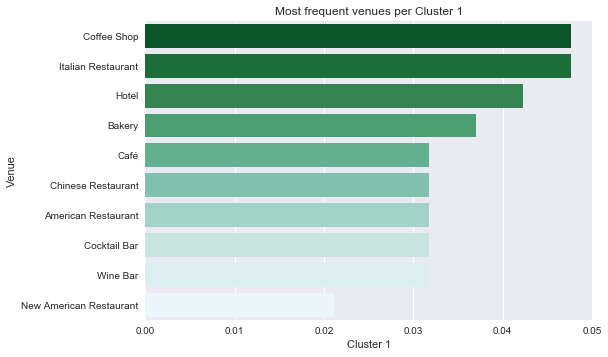

In [39]:
venue_frequency=merged_left.groupby('Cluster Labels').mean().reset_index()
venue_frequency= venue_frequency.set_index('Cluster Labels').transpose()
venue_frequency.reset_index(inplace = True)
venue_frequency.columns = ['Venue', 'Cluster 0', 'Cluster 1','Cluster 2','Cluster 3']
venue_frequency.sort_values(by = ['Cluster 1'], inplace = True, ascending = False)
venue_frequency_top10 = venue_frequency.head(10)
print(venue_frequency_top10.shape)
venue_frequency_top10.reset_index(inplace = True)
venue_frequency_top10=venue_frequency_top10.drop(['Cluster 0','Cluster 2','Cluster 3'],axis=1)
#venue_frequency_top10.sort_values(by = ['Cluster 0'],ascending=False)
ax = sns.barplot(x="Cluster 1", y="Venue", data=venue_frequency_top10,palette="BuGn_r")
ax.set_title('Most frequent venues per Cluster 1')

(10, 5)


Text(0.5, 1.0, 'Most frequent venues in Cluster 2')

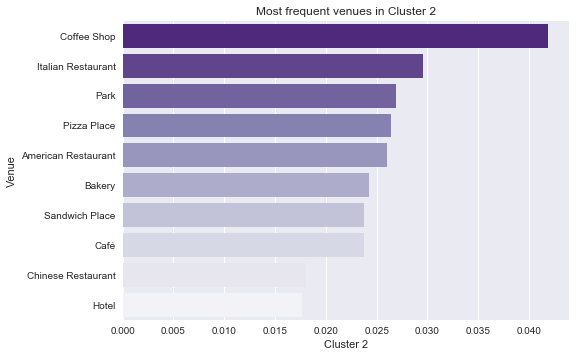

In [40]:
venue_frequency=merged_left.groupby('Cluster Labels').mean().reset_index()
venue_frequency= venue_frequency.set_index('Cluster Labels').transpose()
venue_frequency.reset_index(inplace = True)
venue_frequency.columns = ['Venue', 'Cluster 0', 'Cluster 1','Cluster 2','Cluster 3']
venue_frequency.sort_values(by = ['Cluster 2'], inplace = True, ascending = False)
venue_frequency_top10 = venue_frequency.head(10)
print(venue_frequency_top10.shape)
venue_frequency_top10.reset_index(inplace = True)
venue_frequency_top10=venue_frequency_top10.drop(['Cluster 0','Cluster 1','Cluster 3'],axis=1)
#venue_frequency_top10.sort_values(by = ['Cluster 0'],ascending=False)
ax = sns.barplot(x="Cluster 2", y="Venue", data=venue_frequency_top10,palette="Purples_r")
ax.set_title('Most frequent venues in Cluster 2')

(10, 5)


Text(0.5, 1.0, 'Most frequent venues per Cluster 3')

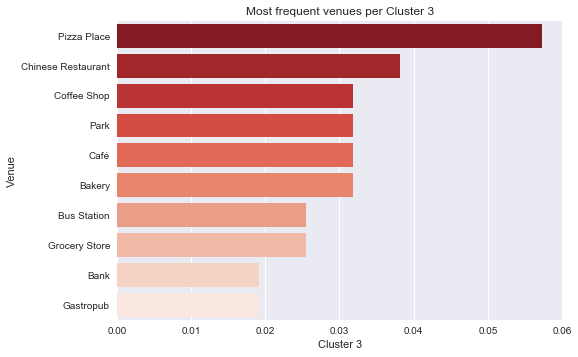

In [41]:
venue_frequency=merged_left.groupby('Cluster Labels').mean().reset_index()
venue_frequency= venue_frequency.set_index('Cluster Labels').transpose()
venue_frequency.reset_index(inplace = True)
venue_frequency.columns = ['Venue', 'Cluster 0', 'Cluster 1','Cluster 2','Cluster 3']
venue_frequency.sort_values(by = ['Cluster 3'], inplace = True, ascending = False)
venue_frequency_top10 = venue_frequency.head(10)
print(venue_frequency_top10.shape)
venue_frequency_top10.reset_index(inplace = True)
venue_frequency_top10=venue_frequency_top10.drop(['Cluster 0','Cluster 1','Cluster 2'],axis=1)
#venue_frequency_top10.sort_values(by = ['Cluster 0'],ascending=False)
ax = sns.barplot(x="Cluster 3", y="Venue", data=venue_frequency_top10,palette="Reds_r")
ax.set_title('Most frequent venues per Cluster 3')

## Conclusion <a name="conclusion"></a>

In this project a classification of two different cities is done. The cities involved are Boston, MA and San Francisco, CA. This is done by grouping venues by neighborhoods, which are the features for the clustering.

The algorithm could divide neighborhoods of both cities in for different clusters. Where in each cluster there are at least 3 neighborhoods in it. With different aspects for each cluster.

This analysis is not perfect due to the limitations of using Foursquare API without a pro account, limiting the calls one can do.
However, this project, is useful for differentiating neighborhoods within a city and finding similar ones in another.
